<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_multivariate_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos adaptation to Multivariate Input: Preprocessing Multivariate Time Series

This notebook is designed to explore preprocessing techniques that transform multivariate time series data into univariate formats suitable for analysis with Chronos. It focuses on two primary preprocessing methods:
1. **Simple Transformation Methods**: Aggregating multiple variables into a single representative feature (Weighted Sum, Arithmetic Mean, Volume Weighted Average Price, PCA).
2. **Machine Learning-Based Methods**: Employ machine learning models to capture the underlying relationships among variables (Linear Regression, Random Forest, Support Vector Regression).

In this notebook, we apply these techniques to Apple stock market data, where the goal is to predict the Close price. The dataset includes multiple financial indicators (Open, High, Low, Volume, Close), and our preprocessing steps will transform these multivariate inputs into a univariate format, enabling the application of Chronos for forecasting. For comparison, we also evaluate Chronos using only the historical values of the Close price as input, without any transformation from multivariate data. This allows us to determine whether incorporating additional variables enhances forecasting performance.

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=e0fdf7fecc6400da04e9e61819d20173f80ab7838aac47225fc3a3084e727fda
  Stored in di

In [30]:
import pandas as pd
import yfinance as yf
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

### Utils

In [3]:
# Function to compute MASE
def mase(y_true, y_pred, y_train):
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast

# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }

# Function to compute the relative score
def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

### Download data and Chronos model

In [4]:
# Set seed for reproducibility
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Download data from Yahoo Finance (AAPL)
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

## Pre-processing (from multivariate to univariate) using simple methods

Define the preprocessing methods:

In [7]:
# Function to calculate PCA
def calculate_pca(data, scaler):
    pca = PCA(n_components=1)
    aapl_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_[0]
    print(f"Explained Variance Ratio of the first component: {explained_variance}")
    return aapl_pca.flatten() * np.sqrt(pca.explained_variance_[0]) + scaler.mean_[3]  # Shift by Close mean

# Solution 1: Weighted Mean (Open, High, Low, Close)
weights = {'Open': 0.2, 'High': 0.3, 'Low': 0.3, 'Close': 0.2}
aapl_combined = (data['Open'] * weights['Open'] +
                 data['High'] * weights['High'] +
                 data['Low'] * weights['Low'] +
                 data['Close'] * weights['Close'])

# Solution 2: Arithmetic Mean (Open, High, Low, Close)
aapl_mean = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Solution 3: Volume Weighted Average Price (VWAP)
aapl_vwap = (data['Volume'] * (data['High'] + data['Low']) / 2).cumsum() / data['Volume'].cumsum()

# Solution 4: Principal Component Analysis (PCA)
aapl_pca_rescaled = calculate_pca(scaled_data, scaler)
aapl_pca_series = pd.Series(aapl_pca_rescaled, index=data.index)

Explained Variance Ratio of the first component: 0.8085689991243603


Chronos prediction using:
1. Only Close prices
2. Univariate input obtained from preprocessing methods

<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Weighted Mean
Variance: [ 279.3557   346.70038  732.84375 1155.2211  1579.0247  1899.4154
 2773.7173  3184.5918  3565.2544  4089.063   4413.07    4727.9097
 5118.702   5417.0947  5580.5737  5803.2515  5974.1475  6224.508
 5865.995   6472.54    6748.9673  6453.6597  6152.5615  5623.505
 5815.5576  5680.4883  5586.1636  5252.8447  4892.069   4695.355  ]


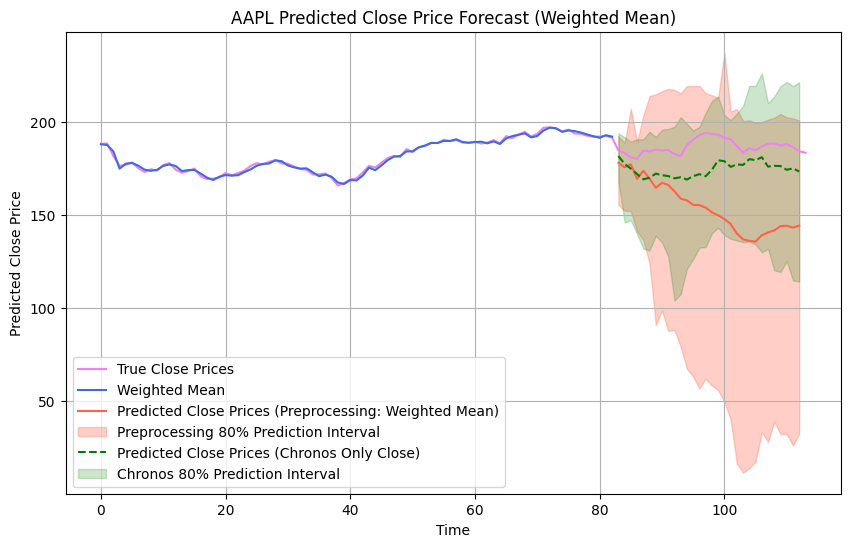

Arithmetic Mean
Variance: [  2.6426268   4.518173    8.956519   15.181714   19.704287   29.06867
  32.52712    42.210743   45.203617   61.34746    68.17562    74.04173
  84.47024    94.04747    93.72821   100.43224   101.784546   96.70775
 103.7355    118.84619   107.28259   115.96864   138.53271   150.22049
 163.4291    195.6724    190.52904   196.91383   211.9403    217.16792  ]


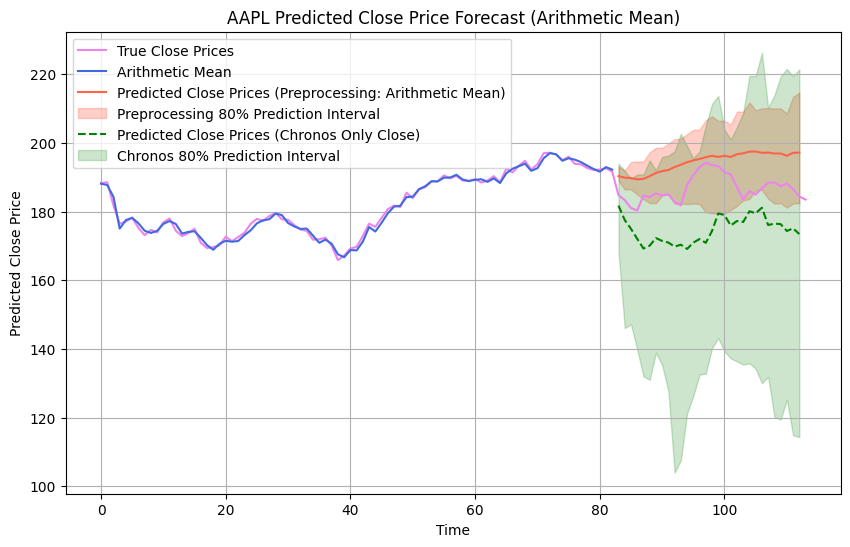

<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


VWAP
Variance: [1896.6477 2234.399  2599.234  2591.6406 2315.1475 2202.085  2134.1255
 2252.124  1880.3601 1830.9332 1735.3346 1917.2634 2068.9375 3014.1465
 3399.0032 4115.234  4270.539  4636.129  4952.6514 5270.6597 5448.945
 5506.1064 5941.783  6040.2666 6132.1665 6221.0283 6074.2695 6216.5483
 5889.2993 5982.581 ]


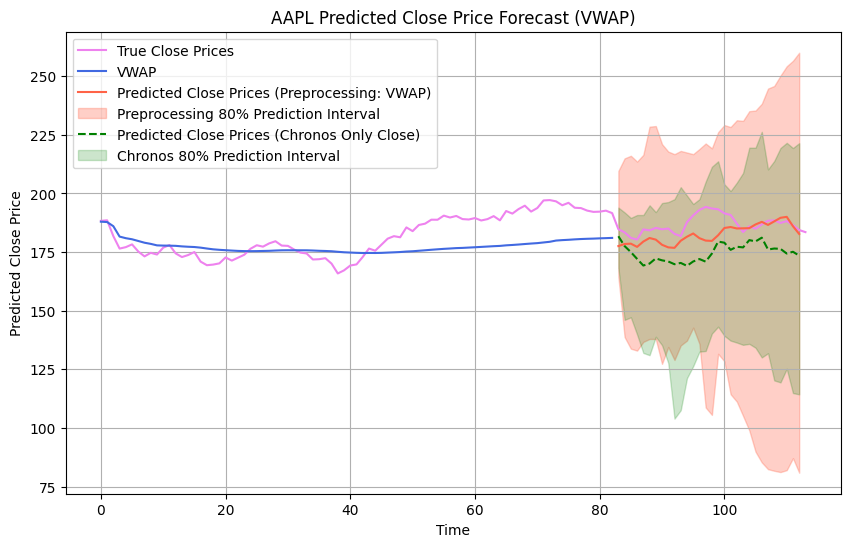

PCA
Variance: [ 0.35518673  2.9125314   3.4453113   3.1034439   3.4630713   6.4644113
  7.6853676   6.6597643   7.352379    7.5299735   7.1215034   6.855104
  7.543289    5.1502075   5.4121575   6.2335367   8.96405    10.207206
 10.939781   11.166217   12.857803   12.942152   14.012154   15.432898
 15.8902025  16.853657   18.16341    19.268927   16.067783   16.232067  ]


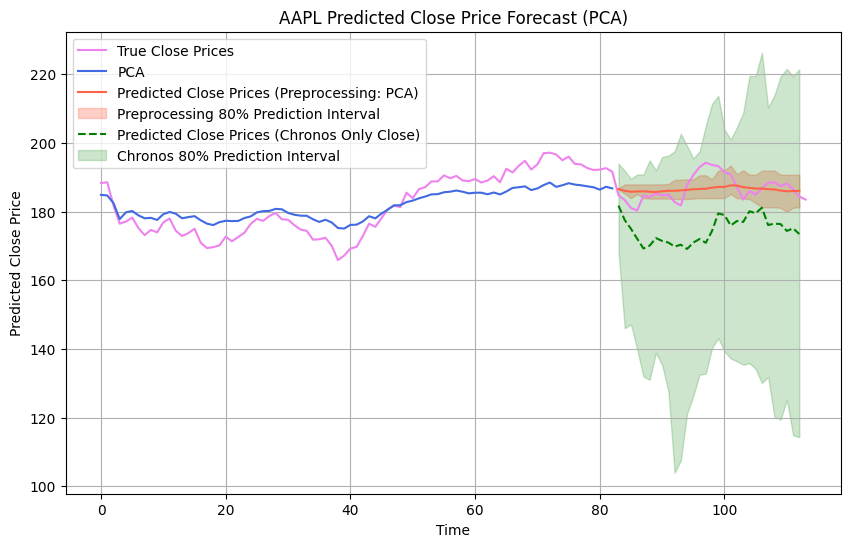

PERFORMANCE METRICS:
                            MSE       RMSE       MAPE      MASE
Chronos Only Close   172.388498  13.129680   6.482399       NaN
Weighted Mean       1287.995346  35.888652  17.392139       NaN
Arithmetic Mean       68.549281   8.279449   4.274226  5.705832
VWAP                  38.572769   6.210698   2.995874       NaN
PCA                   12.035166   3.469174   1.625428  4.348964
-------------------------------------------------
SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):
MSE     0.464146
RMSE    0.681282
MAPE    0.672883
MASE         NaN
dtype: float64


In [29]:
# Dictionary to store metrics
results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=30
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + 30)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict['Close'].values[:30] # True values for comparison
results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'])

# Chronos prediction using preprocessing methods
methods = {
    "Weighted Mean": aapl_combined,
    "Arithmetic Mean": aapl_mean,
    "VWAP": aapl_vwap,
    "PCA": aapl_pca_series
}

for title, close_prices in methods.items():
    # Step 1: Chronos prediction
    forecast = pipeline.predict(
        context=torch.tensor(close_prices.values), prediction_length=30
    )

    forecast_index = range(len(close_prices), len(close_prices) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    # Step 2: Compute metrics
    results[title] = compute_metrics(actual_values, mean_forecast, close_prices.values)

    # Step 3: Visualization
    print(f"{title}")
    print(f'Variance: {variance_forecast}')

    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="True Close Prices")  # True Close Prices
    plt.plot(close_prices.values, color="royalblue", label=f"{title}")  # Close Prices using preprocessing methods

    # Predicted Close Prices using preprocessing methods
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {title})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast ({title})")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()


# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("PERFORMANCE METRICS:")
print(results_df)

# Compute relative performance
relative_scores = agg_relative_score(results_df.iloc[1:], results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

## Pre-processing (from multivariate to univariate) using ML methods

Preprocessing:

In [32]:
# Data preprocessing
scaler = StandardScaler()
X = data[['Open', 'High', 'Low', 'Volume']].values
y = data['Close'].values
X_scaled = scaler.fit_transform(X)

Define the ML methods:

<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression Variance: [2011.6873 1412.3064 2120.8757 2285.696  2748.9038 3122.56   3303.9426
 3755.463  3577.1262 4407.79   4748.43   4638.233  4912.208  4911.677
 4693.831  5161.7764 5426.6416 5493.3203 5751.682  5622.222  5947.4326
 6315.2715 6365.465  6432.547  6538.8223 6985.6157 7512.081  7541.1313
 7784.271  7873.075 ]


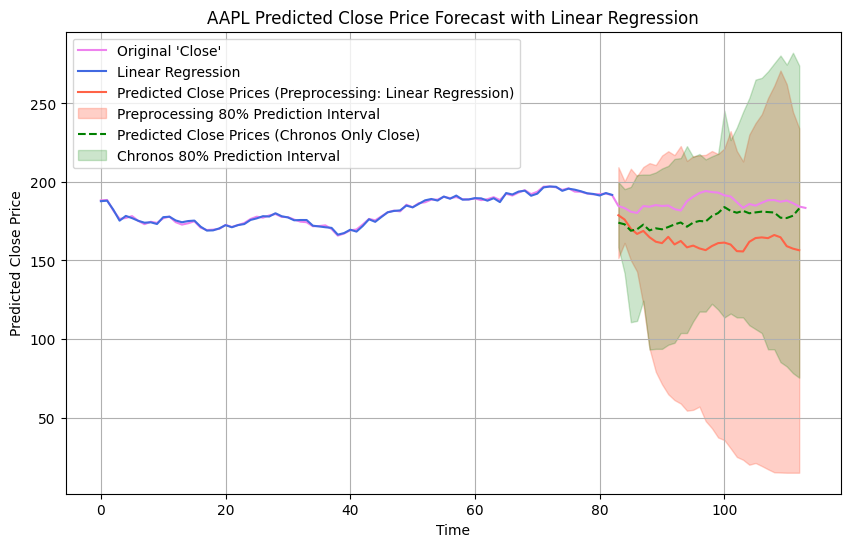

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Variance: [  2.464279    3.8140702   6.908816    9.519598   12.716471   19.731852
  23.314999   25.947979   27.257809   41.577106   48.770103   66.70808
  83.54491    95.2668    102.38428   102.526344  113.21812   119.26113
 128.98935   123.83883   117.83586   119.39878   120.34444   125.8502
 129.84628   120.308914  130.69878   147.14047   185.28978   195.69742  ]


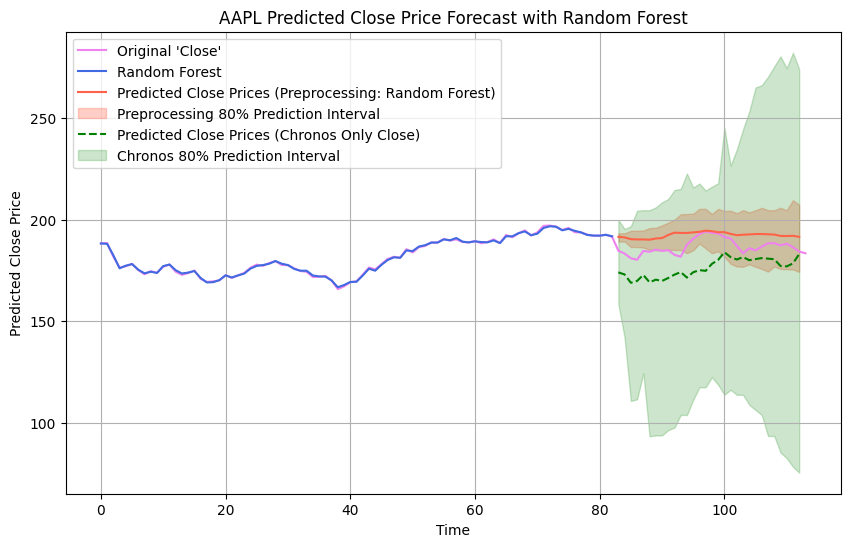

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Regression Variance: [ 2.9246166  4.455708   3.599189   3.0888226  4.8418093  4.544467
  5.5208087  7.433551  15.847847  15.106717  19.455875  22.451466
 23.765083  24.497332  29.978159  32.50332   34.167538  34.811043
 38.325863  36.475243  31.291775  32.059532  37.473793  38.36136
 32.059532  35.019623  42.333298  37.149826  50.10853   54.47544  ]


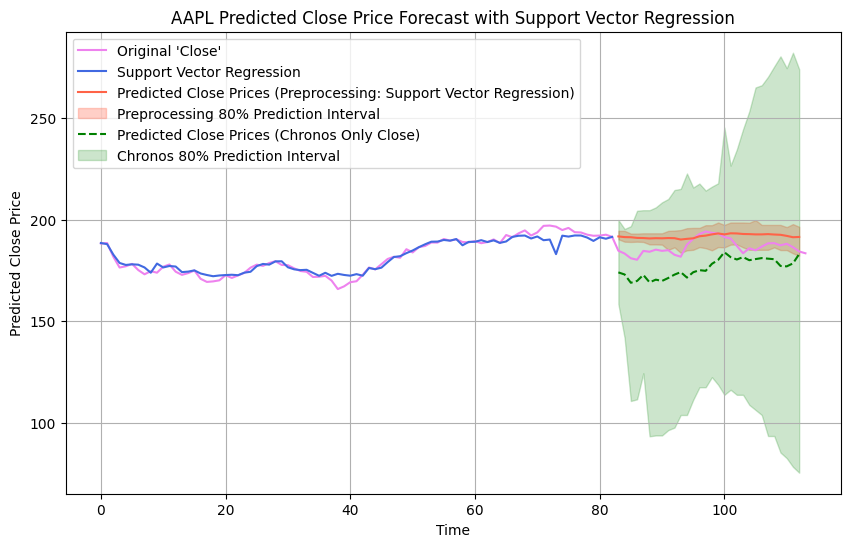

PERFORMANCE METRICS (ML Models):
                                  MSE       RMSE       MAPE      MASE
Chronos Only Close         131.207389  11.454579   5.636803       NaN
Linear Regression          640.670458  25.311469  12.858447       NaN
Random Forest               40.757012   6.384122   3.243007  4.297853
Support Vector Regression   37.310599   6.108240   3.002476  4.075315
-------------------------------------------------
SCALING PERFORMANCE (ML Models vs Chronos Only Close):
MSE     0.755553
RMSE    0.869225
MAPE    0.887508
MASE         NaN
dtype: float64


In [34]:
# ML methods for regression
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=seed),
    "Support Vector Regression": SVR(kernel='rbf')
}

# Dictionary to store metrics for ML models
ml_results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=30
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + 30)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict['Close'].values[:30] # True values for comparison
ml_results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'])


for model_name, model in models.items():
    # Step 1: Fit the model
    model.fit(X_scaled, y)

    # Previsione dei valori di Close
    predicted_close = model.predict(X_scaled)

    # Step 2: Forecasting con Chronos
    forecast = pipeline.predict(
        context=torch.tensor(predicted_close), prediction_length=30
    )

    # Extract forecast statistics
    forecast_index = range(len(predicted_close), len(predicted_close) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    # Store metrics in the results dictionary
    actual_values = data_to_predict['Close'].values[:30]  # True values for comparison
    ml_results[model_name] = compute_metrics(actual_values, mean_forecast, predicted_close)

    print(f"{model_name} Variance: {variance_forecast}")

    # Step 3: Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="Original 'Close'")  # Original Close Prices
    plt.plot(predicted_close, color="royalblue", label=f"{model_name}")  # Predicted Close

    # Predicted Close Prices using Chronos forecast
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {model_name})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast with {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name.replace(' ', '_')}.png")
    plt.show()

# Convert results for ML models to DataFrame
ml_results_df = pd.DataFrame(ml_results).T
print("PERFORMANCE METRICS (ML Models):")
print(ml_results_df)

# Compute relative performance for ML models
relative_scores_ml = agg_relative_score(ml_results_df.iloc[1:], ml_results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (ML Models vs Chronos Only Close):")
print(relative_scores_ml)
